In [1]:
#Import libraries
import pandas as pd 
import re 
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words_en = stopwords.words('English')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly_express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import plotly_express as px
import seaborn as sns

In [2]:
#Adding stopwords
stop_words_en.append('u')
stop_words_en.append('dy')

In [3]:
#Import dataset with pandas
df = pd.read_csv("clickbait_dataset.csv")

In [4]:
#See if there are null elements in the dataframe
df.isnull().sum()

headline     0
clickbait    0
dtype: int64

In [5]:
#Function to clean the text from the dataframe
def limpiar(texto):
    res = texto.lower() #Make lowercase
    res = re.sub(r'[^a-zA-Z0-9\s]', '', res) #Select puntuation symbols or anyother symbol that is not alphanumerical
    res = word_tokenize(res) #Tokenize
    res = [lemmatizer.lemmatize(token) for token in res] #Lemmatize
    res = [token for token in res if token not in stop_words_en] #Delete all stopwords and save it in token
    res = ' '.join(res) #The lemmatizing returns a tupple, so its necessary a join
    return res

In [6]:
#Apply the function and create a new column with the clean text
df['Texto_limpio'] = df['headline'].apply(limpiar)

In [7]:
#Sustitute all 0 to non-clickbait and 1 to clickbait
mapper = {
    0:'non-clickbait',
    1:'clickbait'
}
df['clickbait'] = df['clickbait'].map(mapper)

In [8]:
#Function to create ngrams
def get_enegrams (n,columna):
    vocab = []
    for text in columna:
        n_gram = ngrams(word_tokenize(text), n)
        for ngram in n_gram:
            resultado = ' '.join(ngram)
            vocab.append(resultado)
            
    return pd.Series(vocab). value_counts()

In [9]:
clickbait1 = get_enegrams(1,df[df['clickbait']=='clickbait']['Texto_limpio']) #Saves in a variable all the unigram clickbait
non_clickbait1 = get_enegrams(1,df[df['clickbait'] == 'non-clickbait']['Texto_limpio']) #Saves in a variable all the unigram non-clickbait


In [10]:
#Import image to use it as a mask for wordclouds
mask1 = np.array(Image.open('pointer.png'))
mask1 = 255 - mask1

In [11]:
#Function to render wordclouds
def render_img(ngramas, texto):
    wordcloud_wed = WordCloud(
        width=1200,
        height=1200,
        colormap='magma',
        background_color='White',
        min_font_size=6,
        mask=mask1
    ).generate_from_frequencies(dict(ngramas))

    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud_wed) 
    plt.title(texto)
    plt.axis("off")
    plt.tight_layout()

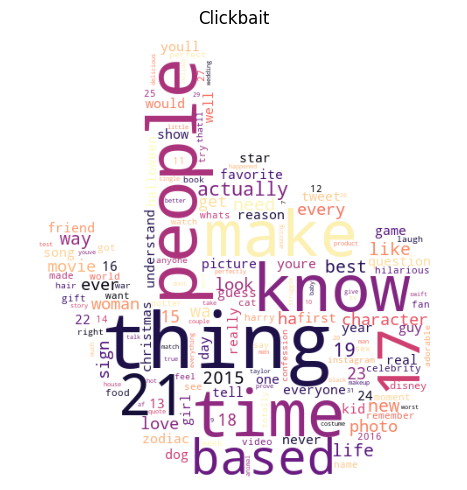

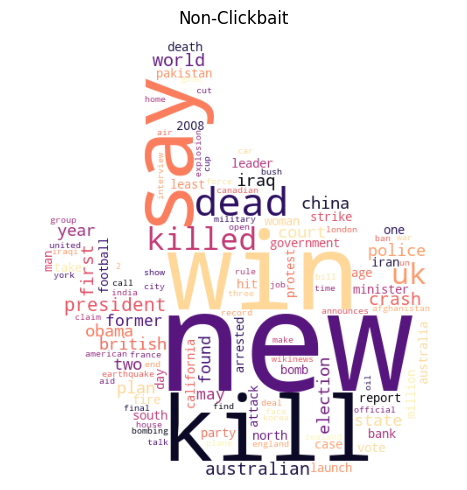

In [12]:
#Rendering wordclouds
render_img(clickbait1,'Clickbait')
render_img(non_clickbait1,'Non-Clickbait')

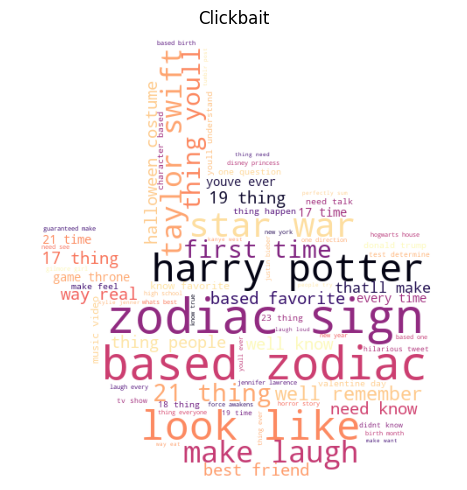

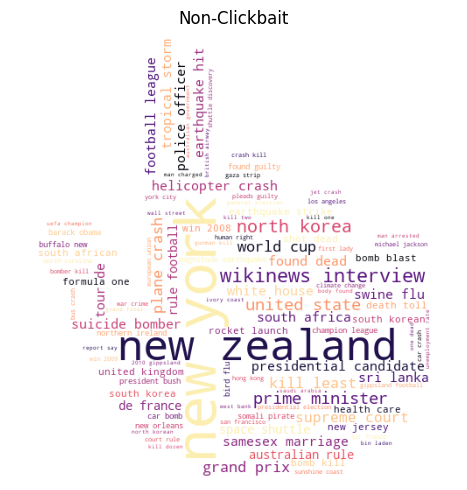

In [13]:
#Creating wordclouds with bigrams

clickbait2 = get_enegrams(2,df[df['clickbait']=='clickbait']['Texto_limpio'])  #Saves in a variable all the bigram clickbait
non_clickbait2 = get_enegrams(2,df[df['clickbait'] == 'non-clickbait']['Texto_limpio'])  #Saves in a variable all the bigram non-clickbait

render_img(clickbait2,'Clickbait') 
render_img(non_clickbait2,'Non-Clickbait')

In [14]:
#Vectorize the text in a range from 1 to 3 ngrams
tfidf = TfidfVectorizer(ngram_range = (1,3)) 
vectorized_text = tfidf.fit_transform(df['Texto_limpio'])

In [15]:
#Count total of clickbaits and non.clickbaits
df['clickbait'].value_counts()

non-clickbait    16001
clickbait        15999
Name: clickbait, dtype: int64

In [16]:
#Using TSNE to visualize vectorized text int 2D
modelo = TSNE(n_components = 2, init = 'random')
resultado = modelo.fit_transform(vectorized_text)
tsne_result_df = pd.DataFrame({'tsne1': resultado[:,0], 'tsne2': resultado[:,1]}) #Is saved in a Dataframe 
tsne_result_df['label'] = df['clickbait']
tsne_result_df['Content'] = df['headline']

In [17]:
#Rendering vectorized words
fig = px.scatter(data_frame = tsne_result_df,
                x = tsne_result_df['tsne1'],
                y = tsne_result_df['tsne2'],
                color = tsne_result_df['label'],
                template = 'plotly_dark',
                hover_data = ['Content'])
fig.show()

In [18]:
X = df['Texto_limpio']
y = df['clickbait']

#Slpitnig data into training and testing
X_train,X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=101) 
tfidf = TfidfVectorizer()

#For the model to train well, it needs to make the testing and training
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#Making a logistic regression model to classify headers "clickbait" and "non-clickbait"
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

In [19]:
#Generating the classification report and the confussion matrix
print(classification_report(y_test,y_pred))

               precision    recall  f1-score   support

    clickbait       0.97      0.94      0.95      4005
non-clickbait       0.94      0.97      0.96      3995

     accuracy                           0.95      8000
    macro avg       0.96      0.95      0.95      8000
 weighted avg       0.96      0.95      0.95      8000



<AxesSubplot: >

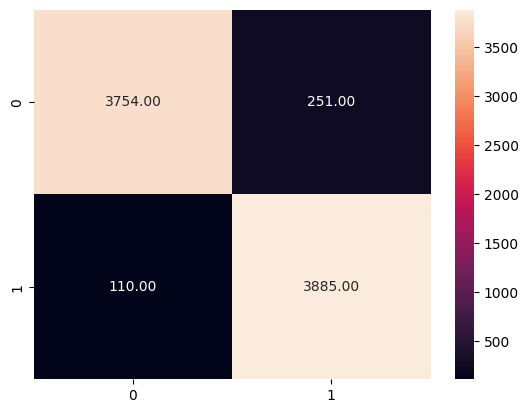

In [20]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt = '.2f')

In [21]:
#Create a function to predict if headlines are clickbait or non-clickbait
def predecir(texto):
    resultado = limpiar(texto)
    resultado = tfidf.transform([resultado])
    prediccion = model.predict(resultado)
    probabilidad = model.predict_proba(resultado)
    return (prediccion, probabilidad)

In [23]:
#Predicting headers
texto = 'New Harry Potters book'
texto2 = 'UEFA champions league tickets with Taylor Swift tickets'
texto3 = 'Buy tickets to the world cup 2 years early'

print(f'{texto}: {predecir(texto)[0]}  Probability: {predecir(texto)[1]}')
print(f'{texto2}: {predecir(texto2)[0]}  Probability: {predecir(texto2)[1]}')
print(f'{texto3}: {predecir(texto3)[0]}  Probability: {predecir(texto3)[1]}')

New Harry Potters book: ['clickbait']  Probability: [[0.84027355 0.15972645]]
UEFA champions league tickets with Taylor Swift tickets: ['non-clickbait']  Probability: [[0.3477568 0.6522432]]
Buy tickets to the world cup 2 years early: ['non-clickbait']  Probability: [[0.17002823 0.82997177]]
